In [19]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import os
import glob
import random
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import StratifiedGroupKFold

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'timm'

In [3]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.get_device_name(1))

NVIDIA RTX A6000
Quadro RTX 8000


In [5]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((1024, 1024)),
    transforms.RandomAffine(degrees=0, translate=(0.007, 0.007)),
    transforms.RandomAffine(degrees=0, shear=(-15, 15)),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.ColorJitter(saturation=0.5),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=(254/255, 0, 0))
])

train_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((1024, 1024)),
    transforms.RandomChoice([transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5)]),
    transforms.RandomAffine(degrees=0, translate=(0.007, 0.007)),
    transforms.RandomAffine(degrees=0, shear=(-15, 15)),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomChoice([transforms.ColorJitter(brightness=(0.5, 1.5)),
                             transforms.ColorJitter(contrast=0.5),
                             transforms.ColorJitter(saturation=0.5),
                             transforms.ColorJitter(hue=0.3)]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=(254/255, 0, 0))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
class CancerDataset(Dataset):
    def __init__(self, df, transform=None):
        super(CancerDataset, self).__init__()
        self.df = df.copy()
        self.transform = transform
        self.path_to_png = "/home/FanHuang247817/train_images_png2/"
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.path_to_png, f"{self.df.loc[idx, 'patient_id']}/{self.df.loc[idx, 'image_id']}.png")
        img = cv2.imread(img_path)
        if self.transform:
            img = self.transform(img)
        label = self.df.loc[idx, "cancer"]
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return img, label
    
    def __len__(self):
        return len(self.df)

In [8]:
class EffNetModel(nn.Module):
    def __init__(self):
        super(EffNetModel, self).__init__()
        backbone = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.DEFAULT)
        backbone.classifier = nn.Linear(1408, 1)
        self.backbone = backbone
        
    def forward(self, dcm):
        out = self.backbone(dcm)
        out = torch.sigmoid(out)
        return out

In [21]:
class ConvNext(nn.Module):
    def __init__(self):
        super(ConvNext, self).__init__()
        backbone = models.convnext_small(weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1)
        backbone.classifier[2] = nn.Linear(in_features=768, out_features=1, bias=True)
        self.backbone = backbone
        
    def forward(self, dcm):
        out = self.backbone(dcm)
        out = torch.sigmoid(out)
        return out

In [9]:
def train_batch(batch, model, criterion, optimizer):
    optimizer.zero_grad()
    
    dcms, labels = batch
    dcms, labels = dcms.to(DEVICE), labels.to(DEVICE)
    
    preds = model(dcms)
    
    loss = criterion(preds, labels)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.cpu().detach().tolist()

In [10]:
def eval_batch(batch, model, criterion):
    dcms, labels = batch
    dcms, labels = dcms.to(DEVICE), labels.to(DEVICE)
    
    preds = model(dcms)

    y_true = labels.cpu().detach().squeeze(1).tolist()
    y_pred = preds.cpu().detach().squeeze(1).tolist()
    
    loss = criterion(preds, labels)
    
    return loss.cpu().detach().tolist(), y_true, y_pred

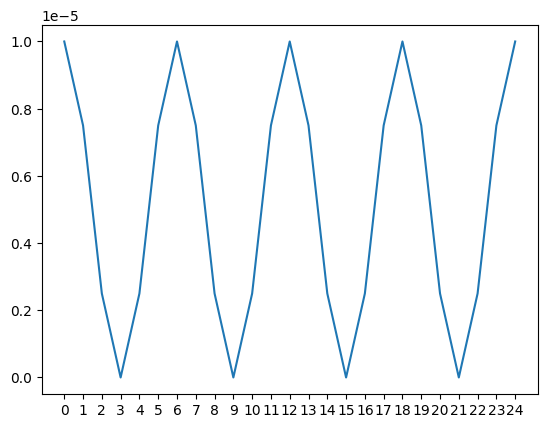

In [27]:
# plot learning rates 
lr = 1e-5
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3)
lrs = []

for i in range(25):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)
plt.xticks(np.arange(0, 25, 1))    
plt.show()

In [28]:
class CustomBatchSampler(torch.utils.data.BatchSampler):
    def __iter__(self):
        batch = [random.choice(pos_indices)]
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                random.shuffle(batch)
                yield batch
                batch = [random.choice(pos_indices)]

In [35]:
def train_loop(train_dataset, val_dataset, pos_indices, n_epoch, fold, batch_size=16, num_workers=8, lr=1e-5):
    log = open(f"./f{fold}/log.txt", 'w')
    
    model = EffNetModel()
    #model = ConvNext()
    model= nn.DataParallel(model, device_ids = [0, 1])
    model.to(DEVICE)

    criterion = nn.BCELoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4)
    #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

    batchsampler = CustomBatchSampler(torch.utils.data.RandomSampler(train_dataset), batch_size=batch_size*2, drop_last=False)
    train_dataloader = DataLoader(train_dataset, batch_sampler=batchsampler, num_workers=num_workers, prefetch_factor=2)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

    train_losses, val_losses, val_roc_aucs = [], [], []
    
    for epoch in range(1, n_epoch + 1):
        print(f"Fold {fold} Epoch {epoch}\n", "-" * 50)
        
        train_loss = 0
        model.train()
        for batch in tqdm(train_dataloader):
            loss = train_batch(batch, model, criterion, optimizer)
            
            with torch.no_grad():
                train_loss += loss
                
            # update the learning rate at every batch
            scheduler.step()
            
        print(f"Train Loss: {train_loss / len(train_dataloader):.4f}")
        
        val_loss = 0
        val_targets, val_outputs = [], []
        model.eval()
        for batch in tqdm(val_dataloader):
            with torch.no_grad():
                loss, y_true, y_pred = eval_batch(batch, model, criterion)
                val_loss += loss
                val_targets.extend(y_true)
                val_outputs.extend(y_pred)
            
        val_roc_auc = roc_auc_score(val_targets, val_outputs)
        print(f"Val Loss: {val_loss / len(val_dataloader):.4f}, ROC_AUC: {val_roc_auc:.4f}")
        print(" ")

        # save model weights
        torch.save(model.state_dict(), f"f{fold}/f{fold}_ep{epoch}_roc_{val_roc_auc:.4f}_vloss_{val_loss / len(val_dataloader):.4f}.pth")

        train_losses.append(train_loss / len(train_dataloader))
        val_losses.append(val_loss / len(val_dataloader))
        val_roc_aucs.append(val_roc_auc)

        # write results to log file
        with open(f"./f{fold}/log.txt", "a") as log:   
            log.write(f"Fold {fold} Epoch {epoch}\n")
            log.write(f"Train Loss: {train_loss / len(train_dataloader):.4f}\n")
            log.write(f"Val Loss: {val_loss / len(val_dataloader):.4f}, ROC_AUC: {val_roc_auc:.4f}\n")
            log.write("\n")

    return train_losses, val_losses, val_roc_aucs

In [ ]:
n_epoch = 50
batch_size = 12
num_workers = 2
lr = 1e-5

train_losses_kfold = []
val_losses_kfold = []
val_roc_aucs_kfold = []

for i in range(4):
    log = open(f"./f{i}/log.txt", 'w')
    log.close()
    
    train_df = pd.read_pickle(f"./df/train_f{i}.pkl")
    val_df = pd.read_pickle(f"./df/val_f{i}.pkl")

    pos_indices = train_df.index[train_df['cancer'] == 1].tolist()
    train_dataset = CancerDataset(train_df, transform=train_transform2)
    val_dataset = CancerDataset(val_df, transform=val_transform)

    train_losses, val_losses, val_roc_aucs = train_loop(train_dataset, val_dataset, pos_indices, n_epoch=n_epoch, 
                                                        fold=i, batch_size=batch_size, num_workers=num_workers, lr=lr)
    train_losses_kfold.append(train_losses)
    val_losses_kfold.append(val_losses)
    val_roc_aucs_kfold.append(val_roc_aucs)

Fold 0 Epoch 1
 --------------------------------------------------


  6%|█████████▏                                                                                                                                              | 24/399 [01:34<21:20,  3.42s/it]Exception in thread Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/FanHuang247817/miniconda3/envs/fanenv/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
QueueFeederThread:
Traceback (most recent call last):
  File "/home/FanHuang247817/miniconda3/envs/fanenv/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/FanHuang247817/miniconda3/envs/fanenv/lib/python3.8/multiprocessing/connection.py", line 177, in close
    close()
  File "/home/FanHuang247817/miniconda3/envs/fanenv/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/FanHuang247817/miniconda3/envs/fanenv/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    self._close()
  File "/home/FanHuang24

Train Loss: 0.5089


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:03<00:00,  2.14it/s]


Val Loss: 0.3392, ROC_AUC: 0.5623
 
Fold 0 Epoch 2
 --------------------------------------------------


416it [24:10,  3.49s/it]                                                                                                                                                                      


Train Loss: 0.3967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:03<00:00,  2.13it/s]


Val Loss: 0.3246, ROC_AUC: 0.5631
 
Fold 0 Epoch 3
 --------------------------------------------------


416it [23:44,  3.42s/it]                                                                                                                                                                      


Train Loss: 0.3941


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:01<00:00,  2.18it/s]


Val Loss: 0.3153, ROC_AUC: 0.5812
 
Fold 0 Epoch 4
 --------------------------------------------------


416it [24:36,  3.55s/it]                                                                                                                                                                      


Train Loss: 0.3918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:57<00:00,  2.25it/s]


Val Loss: 0.3132, ROC_AUC: 0.5963
 
Fold 0 Epoch 5
 --------------------------------------------------


416it [26:43,  3.86s/it]                                                                                                                                                                      


Train Loss: 0.3868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:20<00:00,  1.88it/s]


Val Loss: 0.3063, ROC_AUC: 0.6086
 
Fold 0 Epoch 6
 --------------------------------------------------


416it [29:36,  4.27s/it]                                                                                                                                                                      


Train Loss: 0.3859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:18<00:00,  1.91it/s]


Val Loss: 0.3119, ROC_AUC: 0.6084
 
Fold 0 Epoch 7
 --------------------------------------------------


416it [30:38,  4.42s/it]                                                                                                                                                                      


Train Loss: 0.3843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:24<00:00,  1.83it/s]


Val Loss: 0.3052, ROC_AUC: 0.6233
 
Fold 0 Epoch 8
 --------------------------------------------------


416it [29:39,  4.28s/it]                                                                                                                                                                      


Train Loss: 0.3836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:30<00:00,  1.75it/s]


Val Loss: 0.3055, ROC_AUC: 0.6218
 
Fold 0 Epoch 9
 --------------------------------------------------


416it [30:20,  4.38s/it]                                                                                                                                                                      


Train Loss: 0.3813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:29<00:00,  1.76it/s]


Val Loss: 0.3022, ROC_AUC: 0.6329
 
Fold 0 Epoch 10
 --------------------------------------------------


416it [29:25,  4.24s/it]                                                                                                                                                                      


Train Loss: 0.3798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:30<00:00,  1.75it/s]


Val Loss: 0.3042, ROC_AUC: 0.6242
 
Fold 0 Epoch 11
 --------------------------------------------------


416it [30:05,  4.34s/it]                                                                                                                                                                      


Train Loss: 0.3773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [02:29<00:00,  1.77it/s]


Val Loss: 0.2990, ROC_AUC: 0.6431
 
Fold 0 Epoch 12
 --------------------------------------------------


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 285/399 [20:06<06:52,  3.62s/it]

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(5, 3))
    plt.plot(x, train_history, label='train loss', lw=3, c="springgreen")
    plt.plot(x, val_history, label='validation loss', lw=3, c="deeppink")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.xticks(np.arange(0, 20, 1))
    
    plt.show()

In [ ]:
plot_model_history("EfficientNet_b2 fold0", train_losses_kfold[0], val_losses_kfold[0], num_epochs=n_epoch)

In [ ]:
plot_model_history("EfficientNet_b2 fold1", train_losses_kfold[1], val_losses_kfold[1], num_epochs=n_epoch)

In [ ]:
plot_model_history("EfficientNet_b2 fold2", train_losses_kfold[2], val_losses_kfold[2], num_epochs=n_epoch)

In [ ]:
plot_model_history("EfficientNet_b2 fold3", train_losses_kfold[3], val_losses_kfold[3], num_epochs=n_epoch)

In [ ]:
torch.cuda.empty_cache()